1. Прочитайте базу my_BRENT2019.csv. Сделайте ее перерасчет (ресемплинг) в представление по неделям и перейдите к представлению ряда первыми разностями.
2. Добавьте первые разности по стоимости доллара и евро к рублю (недельные).

3. Постройте модель предсказания 1-й точки от текущей (h=1).

4. Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

%matplotlib inline
import warnings 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import f_regression, mutual_info_regression

In [180]:
df = pd.read_csv('my_BRENT2019.csv', index_col=[0])
df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [181]:
df.tail()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0
2019-08-30,59.19,2019,8,30,3,242,35,4,0,0,0
2019-09-01,58.84,2019,9,1,3,244,35,6,0,1,0


In [182]:
df.index = pd.to_datetime(df.index)

In [183]:
dol = pd.read_excel('RC_F01_09_2010_T01_09_2019_.xlsx', index_col=[1])
dol.head()

,nominal,curs,cdx
data,,,
2010-09-01,1,30.8669,Доллар США
2010-09-02,1,30.8001,Доллар США
2010-09-03,1,30.6858,Доллар США
2010-09-04,1,30.6922,Доллар США
2010-09-07,1,30.5771,Доллар США


In [184]:
dol.drop(columns=['nominal', 'cdx'], inplace=True)

In [185]:
dol.columns = ['dollar']

In [186]:
dol.index = pd.to_datetime(dol.index)

In [187]:
evr = pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx', index_col=[1])
evr.head()

,nominal,curs,cdx
data,,,
2010-09-01,1,39.0127,Евро
2010-09-02,1,39.1654,Евро
2010-09-03,1,39.2901,Евро
2010-09-04,1,39.3505,Евро
2010-09-07,1,39.4720,Евро


In [188]:
evr.drop(columns=['nominal', 'cdx'], inplace=True)

In [189]:
evr.columns = ['euro']

In [190]:
evr.index = pd.to_datetime(evr.index)

In [191]:
df = pd.concat([df, evr, dol], axis=1)

In [192]:
df.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,euro,dollar
2010-09-01,76.37,2010.0,9.0,1.0,3.0,244.0,35.0,2.0,0.0,0.0,0.0,39.0127,30.8669
2010-09-02,76.89,2010.0,9.0,2.0,3.0,245.0,35.0,3.0,0.0,0.0,0.0,39.1654,30.8001
2010-09-03,76.57,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.0,0.0,0.0,39.2901,30.6858
2010-09-04,76.62,2010.0,9.0,4.0,3.0,247.0,35.0,5.0,0.0,0.0,0.0,39.3505,30.6922
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN


In [193]:
df.shape

(3137, 13)

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3137 entries, 2010-09-01 to 2019-09-01
Data columns (total 13 columns):
Значение           2667 non-null float64
year               2667 non-null float64
month              2667 non-null float64
dayofmonth         2667 non-null float64
quarter            2667 non-null float64
dayofyear          2667 non-null float64
weekofyear         2667 non-null float64
dayofweek          2667 non-null float64
is_holiday         2667 non-null float64
is_prev_holiday    2667 non-null float64
is_next_holiday    2667 non-null float64
euro               2228 non-null float64
dollar             2228 non-null float64
dtypes: float64(13)
memory usage: 343.1 KB


In [195]:
df.loc[df['dollar'].isnull()].head(10)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,euro,dollar
2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,NaN,NaN
2010-09-06,76.87,2010.0,9.0,6.0,3.0,249.0,36.0,0.0,1.0,0.0,0.0,NaN,NaN
2010-09-13,79.19,2010.0,9.0,13.0,3.0,256.0,37.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-19,78.23,2010.0,9.0,19.0,3.0,262.0,37.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-20,79.36,2010.0,9.0,20.0,3.0,263.0,38.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-09-26,78.94,2010.0,9.0,26.0,3.0,269.0,38.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-09-27,78.14,2010.0,9.0,27.0,3.0,270.0,39.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-10-03,83.69,2010.0,10.0,3.0,4.0,276.0,39.0,6.0,0.0,0.0,0.0,NaN,NaN
2010-10-04,83.30,2010.0,10.0,4.0,4.0,277.0,40.0,0.0,0.0,0.0,0.0,NaN,NaN
2010-10-10,84.33,2010.0,10.0,10.0,4.0,283.0,40.0,6.0,0.0,1.0,0.0,NaN,NaN


In [196]:
df.loc[df['Значение'].isnull()].head(10)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,euro,dollar
2010-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.8115,31.0826
2010-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.2599,30.9480
2010-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6606,30.5094
2010-10-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6717,29.9086
2010-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3939,30.1243
2010-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.5351,30.4977
2010-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.7256,30.7821
2010-11-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.8779,30.7722
2010-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3568,30.9490
2010-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.6192,31.3539


In [197]:
# df[['Значение','euro','dollar']]
df.fillna(method='ffill', inplace=True)

не совсем корректно относительно календаря, но я потом посомтрю, если календарь влияет на модель, я эти поля пересчитаю все

In [198]:
df_w= df.resample('W').mean()
df_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,euro,dollar
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,39.233840,30.747440
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,39.302883,30.777050
2010-09-19,78.590000,2010.0,9.000000,15.857143,3.000000,258.857143,37.0,2.857143,0.000000,0.0,0.000000,39.984557,30.887129
2010-09-26,78.558571,2010.0,9.000000,22.857143,3.000000,265.857143,38.0,2.857143,0.000000,0.0,0.000000,41.040657,31.003800
2010-10-03,81.582857,2010.0,9.428571,17.000000,3.428571,272.857143,39.0,2.857143,0.000000,0.0,0.000000,41.382686,30.585086


In [199]:
df_w['value_diff'] = df_w['Значение'].diff(1)
df_w['dollar_diff'] = df_w['dollar'].diff(1)
df_w['euro_diff'] = df_w['euro'].diff(1)

In [200]:
df_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,euro,dollar,value_diff,dollar_diff,euro_diff
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,39.233840,30.747440,NaN,NaN,NaN
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,39.302883,30.777050,1.057333,0.029610,0.069043
2010-09-19,78.590000,2010.0,9.000000,15.857143,3.000000,258.857143,37.0,2.857143,0.000000,0.0,0.000000,39.984557,30.887129,0.916667,0.110079,0.681674
2010-09-26,78.558571,2010.0,9.000000,22.857143,3.000000,265.857143,38.0,2.857143,0.000000,0.0,0.000000,41.040657,31.003800,-0.031429,0.116671,1.056100
2010-10-03,81.582857,2010.0,9.428571,17.000000,3.428571,272.857143,39.0,2.857143,0.000000,0.0,0.000000,41.382686,30.585086,3.024286,-0.418714,0.342029


In [201]:
df_w.dropna(inplace=True)  

In [202]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 469 entries, 2010-09-12 to 2019-09-01
Freq: W-SUN
Data columns (total 16 columns):
Значение           469 non-null float64
year               469 non-null float64
month              469 non-null float64
dayofmonth         469 non-null float64
quarter            469 non-null float64
dayofyear          469 non-null float64
weekofyear         469 non-null float64
dayofweek          469 non-null float64
is_holiday         469 non-null float64
is_prev_holiday    469 non-null float64
is_next_holiday    469 non-null float64
euro               469 non-null float64
dollar             469 non-null float64
value_diff         469 non-null float64
dollar_diff        469 non-null float64
euro_diff          469 non-null float64
dtypes: float64(16)
memory usage: 62.3 KB


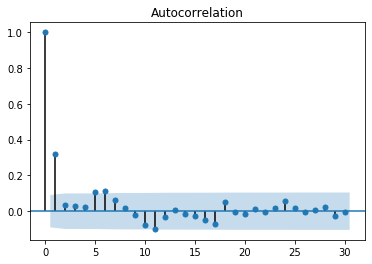

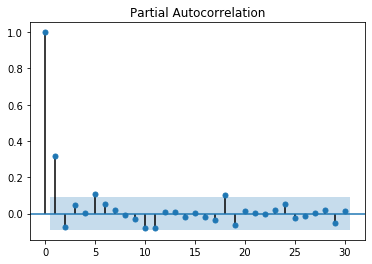

In [203]:
plot_acf(df_w['value_diff'], lags=30)
plt.show()

plot_pacf(df_w['value_diff'], lags=30)
plt.show()

In [204]:
q = 2
p = 2
h = 1

In [205]:
for i in range(p):
    df_w['t'+str(p-i)]=0
    df_w['t'+str(p-i)].values[p:] = df_w['Значение'].values[i:-(p)+i]
    
for i in range(p):
    df_w['d'+str(p-i)]=0
    df_w['d'+str(p-i)].values[p:] = df_w['value_diff'].values[i:-(p)+i]

In [208]:
def split_data(df, split_date):
    return df.loc[df.index.get_level_values(df.index.name) <= split_date].copy(), \
           df.loc[df.index.get_level_values(df.index.name) >  split_date].copy()

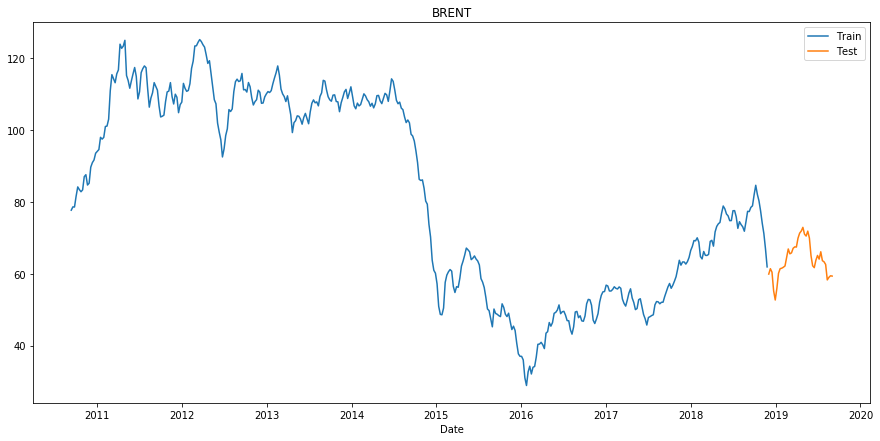

In [213]:
train, test = split_data(df_w, '2018-12-01')

plt.figure( figsize=(15, 7))
plt.plot(train.index,train.iloc[:,0], label='Train' )
plt.plot(test.index,test.iloc[:,0], label='Test')
plt.xlabel('Date')
plt.title('BRENT')
plt.legend(loc='best')
plt.show()

In [206]:
X = df_w.iloc[p:-h,:].values
X.shape

(466, 20)

In [207]:
y = df_w['Значение'].values[h+p:].reshape((df_w.shape[0]-h-p,1))
y.shape

(466, 1)

In [214]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(466, 5)

In [215]:
column_names = df_w.columns[sfk.get_support()]
column_names

Index(['Значение', 'euro', 'dollar', 't2', 't1'], dtype='object')

In [216]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(466, 2)

In [218]:
column_namesp = df_w.columns[sfp.get_support()]
column_namesp

Index(['Значение', 't1'], dtype='object')

In [219]:
gr_model = GradientBoostingRegressor(max_depth=4, random_state=7, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(466, 3)

In [220]:
column_namesp = df_w.columns[sfp.get_support()]
column_namesp

Index(['Значение', 't1'], dtype='object')

In [221]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 16 17]
Номера признаков лучших признаков по процентной форме:  [ 0 17]
Номера признаков для выбора по модели :  [ 0 11 12]


In [222]:
list_par = list(set(np.concatenate((np.concatenate((list_param_k,list_param_p)),list_param_m))))

In [223]:
list_par

[0, 11, 12, 16, 17]

это фактически то что вернула первая функция, т.е. X_new1

In [251]:
X_new = X_new1.copy()

In [256]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [261]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((429, 5), (429,), (37, 5), (37,))

In [262]:
scx= StandardScaler().fit(X_train)
X_train_s = scx.transform(X_train)
X_test_s = scx.transform(X_test)

scy= StandardScaler().fit(y_train.reshape(y_train.shape[0], 1))
y_train_s = scy.transform(y_train.reshape(y_train.shape[0], 1))
y_test_s = scy.transform(y_test.reshape(y_test.shape[0], 1))

In [263]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100)

In [270]:
model_g.fit(X_train_s, y_train_s)

C:\Users\marchenko-i-u\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=40, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [271]:
y_pred_test_gb = model_g.predict(X_test_s)

In [273]:
scy.inverse_transform(y_pred_test_gb)

array([60.6843753 , 58.91330398, 54.75982065, 58.14617537, 61.37904489,
       62.16755976, 60.86443536, 60.99215767, 61.22328732, 64.89494487,
       65.78091641, 66.18307095, 65.34912884, 66.399373  , 68.59141262,
       68.59141262, 68.9211126 , 68.79048099, 73.17307396, 72.90409093,
       67.51089274, 67.25777337, 72.96057381, 67.69587689, 63.22057484,
       60.97657285, 60.93142991, 63.4476916 , 65.36831485, 64.30212393,
       66.06017674, 63.50255405, 62.88779711, 62.67308037, 58.23464441,
       59.43195643, 60.58801925])

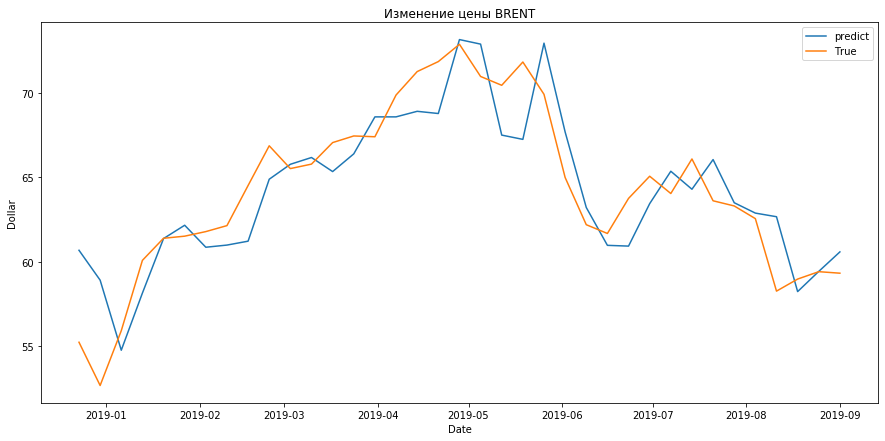

In [275]:
plt.figure( figsize=(15, 7))
plt.plot(test.index[h+p:],scy.inverse_transform(y_pred_test_gb), label='predict' )
plt.plot(test.index[h+p:],scy.inverse_transform(y_test_s), label='True')
plt.xlabel('Date')
plt.title('Изменение цены BRENT')
plt.ylabel('Dollar')
plt.legend()
plt.show()

In [276]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [277]:
er_g = mean_absolute_percentage_error(y_true=scy.inverse_transform( y_test_s),y_pred = scy.inverse_transform( y_pred_test_gb))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   8.219340463568592 %
